In [1]:
import random
import numpy as np
import scipy.io.wavfile
import scipy.signal
import numpy as np
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPool1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
import tensorflow as tf
from tensorflow.keras.layers import Dropout


class DataKeeper:
    def __init__(self):
        self.RawDatas = []
        self.RawLabel = []
    def AddNewType(self, data, label):
        self.RawDatas.append(data)
        self.RawLabel.append(label)
    
    @property
    def KeptTypeCount(self):
        return len(self.RawDatas)
    
    def GetData(self, index):
        return self.RawDatas[index]
    
    def GenerateTrainTestValid(self, alpha=0.8):
        #ha alpha 0.8 -> train: 80%, valid: 10%, test: 10%
        SumRawDatas = []
        #létrehozzuk a teljes adatállományt egy tömbben
        for x in range(0, len(self.RawDatas)):
            for element in self.RawDatas[x]:
                SumRawDatas.append([element,self.RawLabel[x]])
        #összekeverjük
        random.shuffle(SumRawDatas)
        #szétválogatjuk 3 részre
        train = SumRawDatas[:int(len(SumRawDatas)*alpha)]
        test_valid = SumRawDatas[int(len(SumRawDatas)*alpha):]
        test = test_valid[:int(len(test_valid)*0.5)]
        valid = test_valid[int(len(test_valid)*0.5):]
        
        #x_train, y_train létrehozása
        self.x_train = []
        self.y_train = []
        for x in train:
            self.x_train.append(x[0])
            self.y_train.append(x[1])
            
        #x_test, y_test létrehozása
        self.x_test = []
        self.y_test = []
        for x in test:
            self.x_test.append(x[0])
            self.y_test.append(x[1])
            
        #x_valid, y_valid létrehozása
        self.x_valid = []
        self.y_valid = []
        for x in train:
            self.x_valid.append(x[0])
            self.y_valid.append(x[1])
            
        #numpy tömbbe konvertálás
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        
        self.x_valid = np.array(self.x_valid)
        self.y_valid = np.array(self.y_valid) 
        print("Kész")

In [2]:
def WavToSplittedArray(filename="", window_size = 100):
    fs, wave = scipy.io.wavfile.read(filename) 
    windows_count = int(len(wave)/window_size)

    kimenet = []
    for i in range(windows_count):
      buffer = []
      for x in range(window_size):
        buffer.append(wave[i*window_size+x])
      kimenet.append(buffer)
    return kimenet

In [4]:
ablakmeret = 15000

Adatgyujto = DataKeeper()

Adatgyujto.AddNewType(WavToSplittedArray("sounds/1lehuzva_mono.wav", ablakmeret), 0)
Adatgyujto.AddNewType(WavToSplittedArray("sounds/2lehuzva_mono.wav", ablakmeret), 1)
Adatgyujto.AddNewType(WavToSplittedArray("sounds/alapjarat_mono.wav", ablakmeret),2)


In [5]:
Adatgyujto.GenerateTrainTestValid()

Kész


In [8]:
tf.compat.v1.reset_default_graph()
clear_session            
lstm_size = 20

# Model
#######

input_shape=(ablakmeret, 1)

x = Input(shape=input_shape)

# Hidden layers

#d0_layer = Dropout(.3)(x)

lstmlayer = LSTM(lstm_size, return_sequences=True)(x)
lstmlayer2 = LSTM(lstm_size, return_sequences=False)(lstmlayer)


dense1 = Dense(units=50, activation="relu")(lstmlayer2)
#dropout3 = Dropout(rate=0.3)(dense1)
dense2 = Dense(units=30, activation="relu")(dense1)
#dropout4 = Dropout(rate=0.3)(dense2)
predictions = Dense(units = 3, activation='softmax')(dense2)



model = Model(inputs=x, outputs=predictions)


model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15000, 1)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 15000, 20)         1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 50)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93        
Total params: 7,713
Trainable params: 7,713
Non-trainable params: 0
___________________________________________________________

In [ ]:
# Loss 

loss = sparse_categorical_crossentropy#TODO use the imported loss!

# Optimizer

optimizer = Adam() # A "smart" SGD variant 
 
# Compilation
#############

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) #TODO what to measure here?

#x_train.reshape(Adatgyujto.x_train.shape[0], 1, Adatgyujto.x_train.shape[1])


history = model.fit(x=Adatgyujto.x_train, y=Adatgyujto.y_train,
                    validation_data=(Adatgyujto.x_valid, Adatgyujto.y_valid),
                    epochs=10,
                    batch_size=50)

Epoch 1/10
10/10 [==============================] - 273s 28s/step - loss: 1.0421 - accuracy: 0.6209 - val_loss: 0.8991 - val_accuracy: 0.7100
Epoch 2/10
10/10 [==============================] - 266s 27s/step - loss: 0.8853 - accuracy: 0.6910 - val_loss: 0.8097 - val_accuracy: 0.7100
Epoch 3/10
10/10 [==============================] - 285s 29s/step - loss: 0.8092 - accuracy: 0.7075 - val_loss: 0.8092 - val_accuracy: 0.7100
Epoch 4/10
 4/10 [===========>..................] - ETA: 2:46 - loss: 0.7996 - accuracy: 0.7179

In [22]:
predikalando = 18

pred = model.predict(Adatgyujto.x_test[predikalando].reshape(1,ablakmeret))

print("ennek kene hogy legyen: " + str(Adatgyujto.y_test[predikalando]))
pred

ennek kene hogy legyen: 1


array([[0.15152241, 0.1194277 , 0.7290499 ]], dtype=float32)

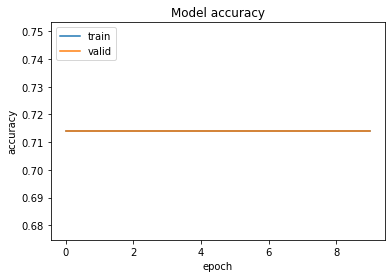

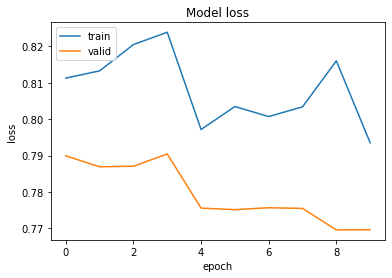

In [23]:
import matplotlib.pyplot as plt

def display_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history)

In [24]:
model.save("KerasModels/LSTM.h5")